# Lift chart

Lift chart - одна из метрик качества предсказательных моделей. Ее преимущество в том, что в отличии например от roc-кривой её очень легко презентовать и интерпретировать. Представьте, что у вас есть база клиентов, которую нужно обзвонить и что-то продать. Наверное вы построите модель, которая будет предсказывать вероятность положительного отклика клиента и будете звонить клиентам в порядке убывания вероятности. Но как объяснить вашему заказчику, какое преимущество он получит, используюя вашу модель? Lift chart позволит это очень хорошо объяснить. Давайте смоделируем какие-нибудь данные, постоим модель и проанализируем ее. Я сгенерирую два класса, которые довольно трудно отделить один от другого. Всего у нас будет 1000 клиентов и только 500 из них откликнуться на наше предложение.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn
seaborn.set(font='arial')
%matplotlib inline

//anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


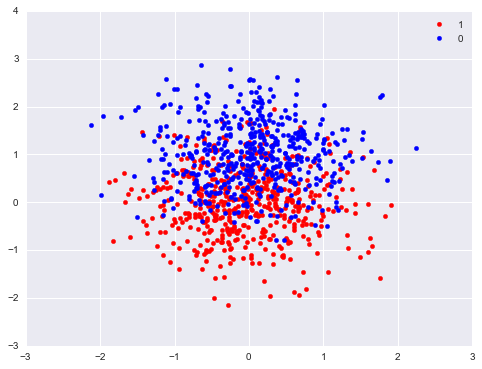

In [2]:
np.random.seed(0)

data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=500)
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=500)

plt.figure(figsize=(8, 6))
plt.scatter(data_0[:,0], data_0[:,1], color='red',label='1')
plt.scatter(data_1[:,0], data_1[:,1], color='blue',label='0')
plt.legend()

Синий цвет - нет отклика, красный цвет - есть отклик. Создадим обучающую и тестовую выборки.

In [3]:
X = np.vstack([data_0,data_1])
y = np.hstack([np.zeros(500),np.ones(500)])
X_train, X_test, y_train, y_test = train_test_split(X,y)

Обучим логистическую регрессию и посмотрим на ее качество.

In [4]:
regressor = LogisticRegression()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test) # порог 0.5
y_pred_proba = regressor.predict_proba(X_test)[:,1]

Посмотрим на точность.

In [5]:
print accuracy_score(y_test,y_pred)

0.756


Построим roc-кривую.

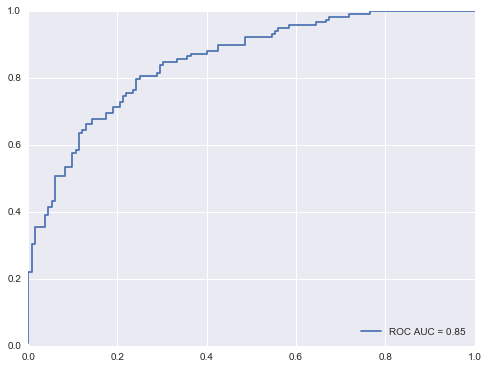

In [6]:
roc_auc = roc_auc_score(y_test,y_pred_proba)
tpr, fpr, thr = roc_curve(y_test,y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(tpr,fpr,label='ROC AUC = {:.2f}'.format(roc_auc))
plt.legend(loc='lower right')

Получив эти значения ([кстати про метрики тоже можно у меня почитать](http://glebmikhaylov.com/метрики-качества/)) вы бежите к заказчику и говорите: "Смотри, как круто! Надо срочно начинать обзвон!" Заказчик говорит: "Хм, классно. Я ничего не понимаю. На сколько это лучше, чем просто звонить всем подряд?" Вот тут-то вам и пригодиться lift chart.

Давайте как-нибудь визуализируем случайный обзвон. Представим, что сам обзвон производиться в десять подходов. Какую долю положительных откликов мы будем иметь на каждом этапе? Проиллюстрирую это таблицей для нашего случая.

In [7]:
df = pd.DataFrame({u'Кол-во клиентов':[100]*10,
                   u'Кол-во положительных откликов':[100*0.5]*10})
df

,Кол-во клиентов,Кол-во положительных откликов
0,100,50.0
1,100,50.0
2,100,50.0
3,100,50.0
4,100,50.0
5,100,50.0
6,100,50.0
7,100,50.0
8,100,50.0
9,100,50.0


Теперь посчитаем накопительных итог по каждому столбцу в процентах от общей суммы и выведем график.

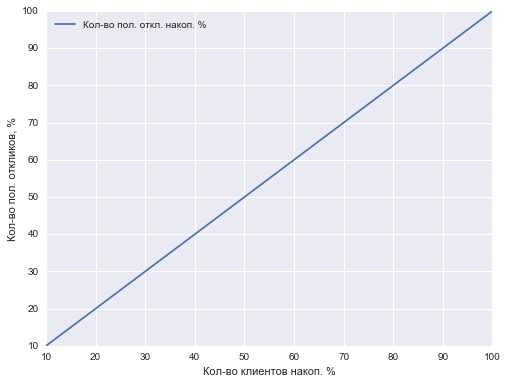

In [8]:
df[u'Кол-во клиентов накоп. %'] = 100 * df[u'Кол-во клиентов'].cumsum()/ \
                                 df[u'Кол-во клиентов'].sum()
    
df[u'Кол-во пол. откл. накоп. %'] = 100 * df[u'Кол-во положительных откликов'].cumsum()/ \
                                   df[u'Кол-во положительных откликов'].sum()
    
df.plot(u'Кол-во клиентов накоп. %',u'Кол-во пол. откл. накоп. %',figsize=(8, 6))
plt.ylabel(u'Кол-во пол. откликов, %')

Интерпретировать нужно так: обзвонив 10% клиентов, мы получим 10% положительных откликов (из всех возможных), обзвонив 20% - 20% и т.д. Теперь пришло время построить подобный график для нашей модели. Для этого нужно отсортировать клиентов в порядке убывания вероятности отклика и сравнить в реальным откликом (по тестовой выборке).

In [9]:
df = pd.DataFrame({u'Вероятность отклика':y_pred_proba,u'Реальный отклик':y_test})
df.sort_values(u'Вероятность отклика',ascending=False,inplace=True)
df.head()

,Вероятность отклика,Реальный отклик
185,0.992558,1.0
236,0.987875,1.0
61,0.982945,1.0
128,0.982134,1.0
142,0.979349,1.0


Далее нужно сделать тоже самое, что и в случае со случайным обзвоном. Сначала посчитаем кол-во клиентов, которым позвонили, накопленным итогом в процентах.

In [10]:
df[u'Кол-во клиентов'] = 1
df[u'Кол-во клиентов накоп. %'] = 100 * df[u'Кол-во клиентов'].cumsum() / df[u'Кол-во клиентов'].sum()
df.head()

,Вероятность отклика,Реальный отклик,Кол-во клиентов,Кол-во клиентов накоп. %
185,0.992558,1.0,1,0.4
236,0.987875,1.0,1,0.8
61,0.982945,1.0,1,1.2
128,0.982134,1.0,1,1.6
142,0.979349,1.0,1,2.0


Побьем их на децили (т.е. на десять равных частей), сгруппируем и просуммируем (добавим еще строчку с [0,0], чтобы график смотрелся более красиво).

In [11]:
decile = pd.cut(df[u'Кол-во клиентов накоп. %'],
                  np.arange(0,1.1,0.1)*100,
                  labels=np.arange(0.1,1.1,0.1)*100)

df = df.groupby(decile)[u'Реальный отклик'].sum().reset_index()
df = pd.DataFrame(np.concatenate([[[0,0]],df.values,]),columns=df.columns)
df

,Кол-во клиентов накоп. %,Реальный отклик
0,0,0
1,10,25
2,20,20
3,30,18
4,40,17
5,50,13
6,60,9
7,70,7
8,80,5
9,90,4


И теперь осталось только посчитать накопленный итог в процентах по реальному отклику. И построить график. На графике сразу же отобразим график случайной модели.

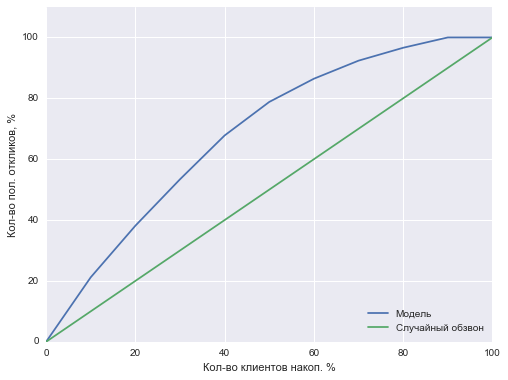

In [12]:
df[u'Реальный отклик накоп. %'] = 100 * df[u'Реальный отклик'].cumsum()/df[u'Реальный отклик'].sum()
df[u'Кол-во клиентов накоп. %'] = df[u'Кол-во клиентов накоп. %'].astype('float64')
df.plot(u'Кол-во клиентов накоп. %',
        u'Реальный отклик накоп. %',
        xlim=[0,100],ylim=[0,110],
       label=u'Модель',figsize=(8, 6))

plt.plot(df[u'Кол-во клиентов накоп. %'],
         df[u'Кол-во клиентов накоп. %'],
        label=u'Случайный обзвон')
plt.legend(loc='lower right')
plt.ylabel(u'Кол-во пол. откликов, %')

На этой диаграмме видно, какое преимущество дает наша модель на каждом этапе обзвона. Например можно увидеть, что обзвонив только 20% базы, мы получаем почти 40% всех положительных откликов, т.е. в два раза больше чем при случайном обзвоне. Теперь можно построить и сам lift chart. Для этого расчитаем lift, т.е отношение отклика по моделе и случайного обзвона.

In [13]:
df = df.loc[1:] # нулевой дециль нам больше не нужен
df['lift'] = df[u'Реальный отклик накоп. %']/(df[u'Кол-во клиентов накоп. %'])
df

/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Кол-во клиентов накоп. %,Реальный отклик,Реальный отклик накоп. %,lift
1,10.0,25,21.1864,2.11864
2,20.0,20,38.1356,1.90678
3,30.0,18,53.3898,1.77966
4,40.0,17,67.7966,1.69492
5,50.0,13,78.8136,1.57627
6,60.0,9,86.4407,1.44068
7,70.0,7,92.3729,1.31961
8,80.0,5,96.6102,1.20763
9,90.0,4,100,1.11111
10,100.0,0,100,1


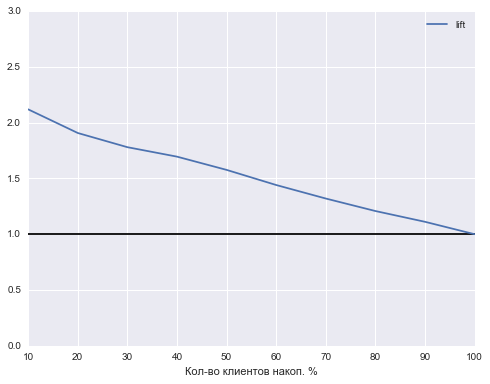

In [14]:
df.plot(u'Кол-во клиентов накоп. %','lift',ylim=[0,3],figsize=(8, 6))
plt.hlines(1,0,100)

Теперь презентуя свою модель заказчику, вы можете объяснить ему, что при использовании вашей модели обзвовон будет в полтора раза эффективнее, чем без модели:

In [15]:
df.lift.mean()

1.5155299973096583

Так же можно сказать, что обзвонив 50% базы, вы получите 80% всех положительных откликов:

In [16]:
df[df[u'Кол-во клиентов накоп. %'] == 50]

,Кол-во клиентов накоп. %,Реальный отклик,Реальный отклик накоп. %,lift
5,50.0,13,78.8136,1.57627


Надеюсь, что статья понравилась. До новых встреч!)